# Predictive Maintenance of Turbofan Jet Engine: Data Preprocessing


## 1. Load dataset


In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from utils import read_dataset, calculate_RUL, SENSOR_COLUMNS

In [2]:
train, test, test_rul = read_dataset("FD001")
train.shape, test.shape, test_rul.shape

((20631, 26), (13096, 26), (100,))

## 2. Handle null values


In [3]:
train.isnull().sum()

unit            0
time_cycles     0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
sensor_20       0
sensor_21       0
dtype: int64

Our training data has 0 null value.


## 3. Add Remaining Useful Life (RUL)


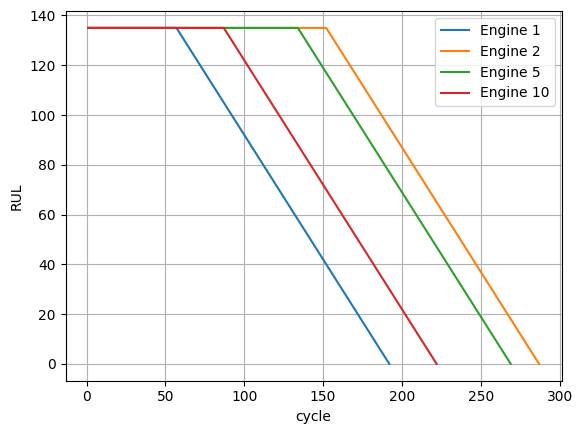

In [4]:
train["rul"] = calculate_RUL(train, upper_threshold=135)

for _unit in [1, 2, 5, 10]:
    plt.plot(
        train[train["unit"] == _unit]["time_cycles"],
        train[train["unit"] == _unit]["rul"],
        label=f"Engine {_unit}",
    )

plt.legend()
plt.xlabel("cycle")
plt.ylabel("RUL")
plt.grid()
plt.show()

## 4. Remove Features with Low Correlation


In [5]:
corr = train.corr()["rul"].abs().sort_values(ascending=False)
print(corr)

rul             1.000000
sensor_11       0.769662
time_cycles     0.755796
sensor_4        0.751705
sensor_12       0.743360
sensor_7        0.727802
sensor_15       0.714847
sensor_21       0.702201
sensor_20       0.699407
sensor_17       0.675436
sensor_2        0.672701
sensor_3        0.649536
sensor_8        0.619891
sensor_13       0.619302
sensor_9        0.455894
sensor_14       0.364142
sensor_6        0.112056
unit            0.033918
op_setting_2    0.006521
op_setting_1    0.005232
op_setting_3         NaN
sensor_1             NaN
sensor_5             NaN
sensor_10            NaN
sensor_16            NaN
sensor_18            NaN
sensor_19            NaN
Name: rul, dtype: float64


Observations:

- From EDA, we know that Operational Setting 3 and Sensor 1, 5, 10, 16, 18, 19 are constant.
- Since they have zero variance with number of cycles, they are useless.
- We can use Scikit-Learn VarianceThreshold to remove uncorrelated features.


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold


class LowVarianceFeaturesRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0):
        self.threshold = threshold
        self.selector = VarianceThreshold(threshold=threshold)

    def fit(self, X):
        self.selector.fit(X)
        return self

    def transform(self, X):
        X_t = self.selector.transform(X)
        droped_features = X.columns[~self.selector.get_support()]
        print(f"Dropped low variance features: {droped_features.to_list()}")
        return pd.DataFrame(X_t, columns=self.selector.get_feature_names_out())

In [7]:
# Apply LowVarianceFeaturesRemover and list out remaining features
train = LowVarianceFeaturesRemover(threshold=0).fit_transform(train)

Dropped low variance features: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


## 5. Scaling per Engine


As suggested from EDA, we need to scale the sensor time series with respect to start of every individual engines time series.


In [8]:
class ScalePerEngine(BaseEstimator, TransformerMixin):
    def __init__(self, n_first_cycles=20, sensors_columns=SENSOR_COLUMNS):
        self.n_first_cycles = n_first_cycles
        self.sensors_columns = sensors_columns

    def fit(self, X):
        return self

    def transform(self, X):
        self.sensors_columns = [x for x in X.columns if x in self.sensors_columns]

        init_sensors_avg = (
            X[X["time_cycles"] <= self.n_first_cycles]
            .groupby(by=["unit"])[self.sensors_columns]
            .mean()
            .reset_index()
        )

        X_t = X[X["time_cycles"] > self.n_first_cycles].merge(
            init_sensors_avg, on=["unit"], how="left", suffixes=("", "_init_v")
        )

        for SENSOR in self.sensors_columns:
            X_t[SENSOR] = X_t[SENSOR] - X_t["{}_init_v".format(SENSOR)]

        drop_columns = X_t.columns.str.endswith("init_v")
        return X_t[X_t.columns[~drop_columns]]

In [9]:
train = ScalePerEngine(n_first_cycles=15, sensors_columns=SENSOR_COLUMNS).fit_transform(
    train
)

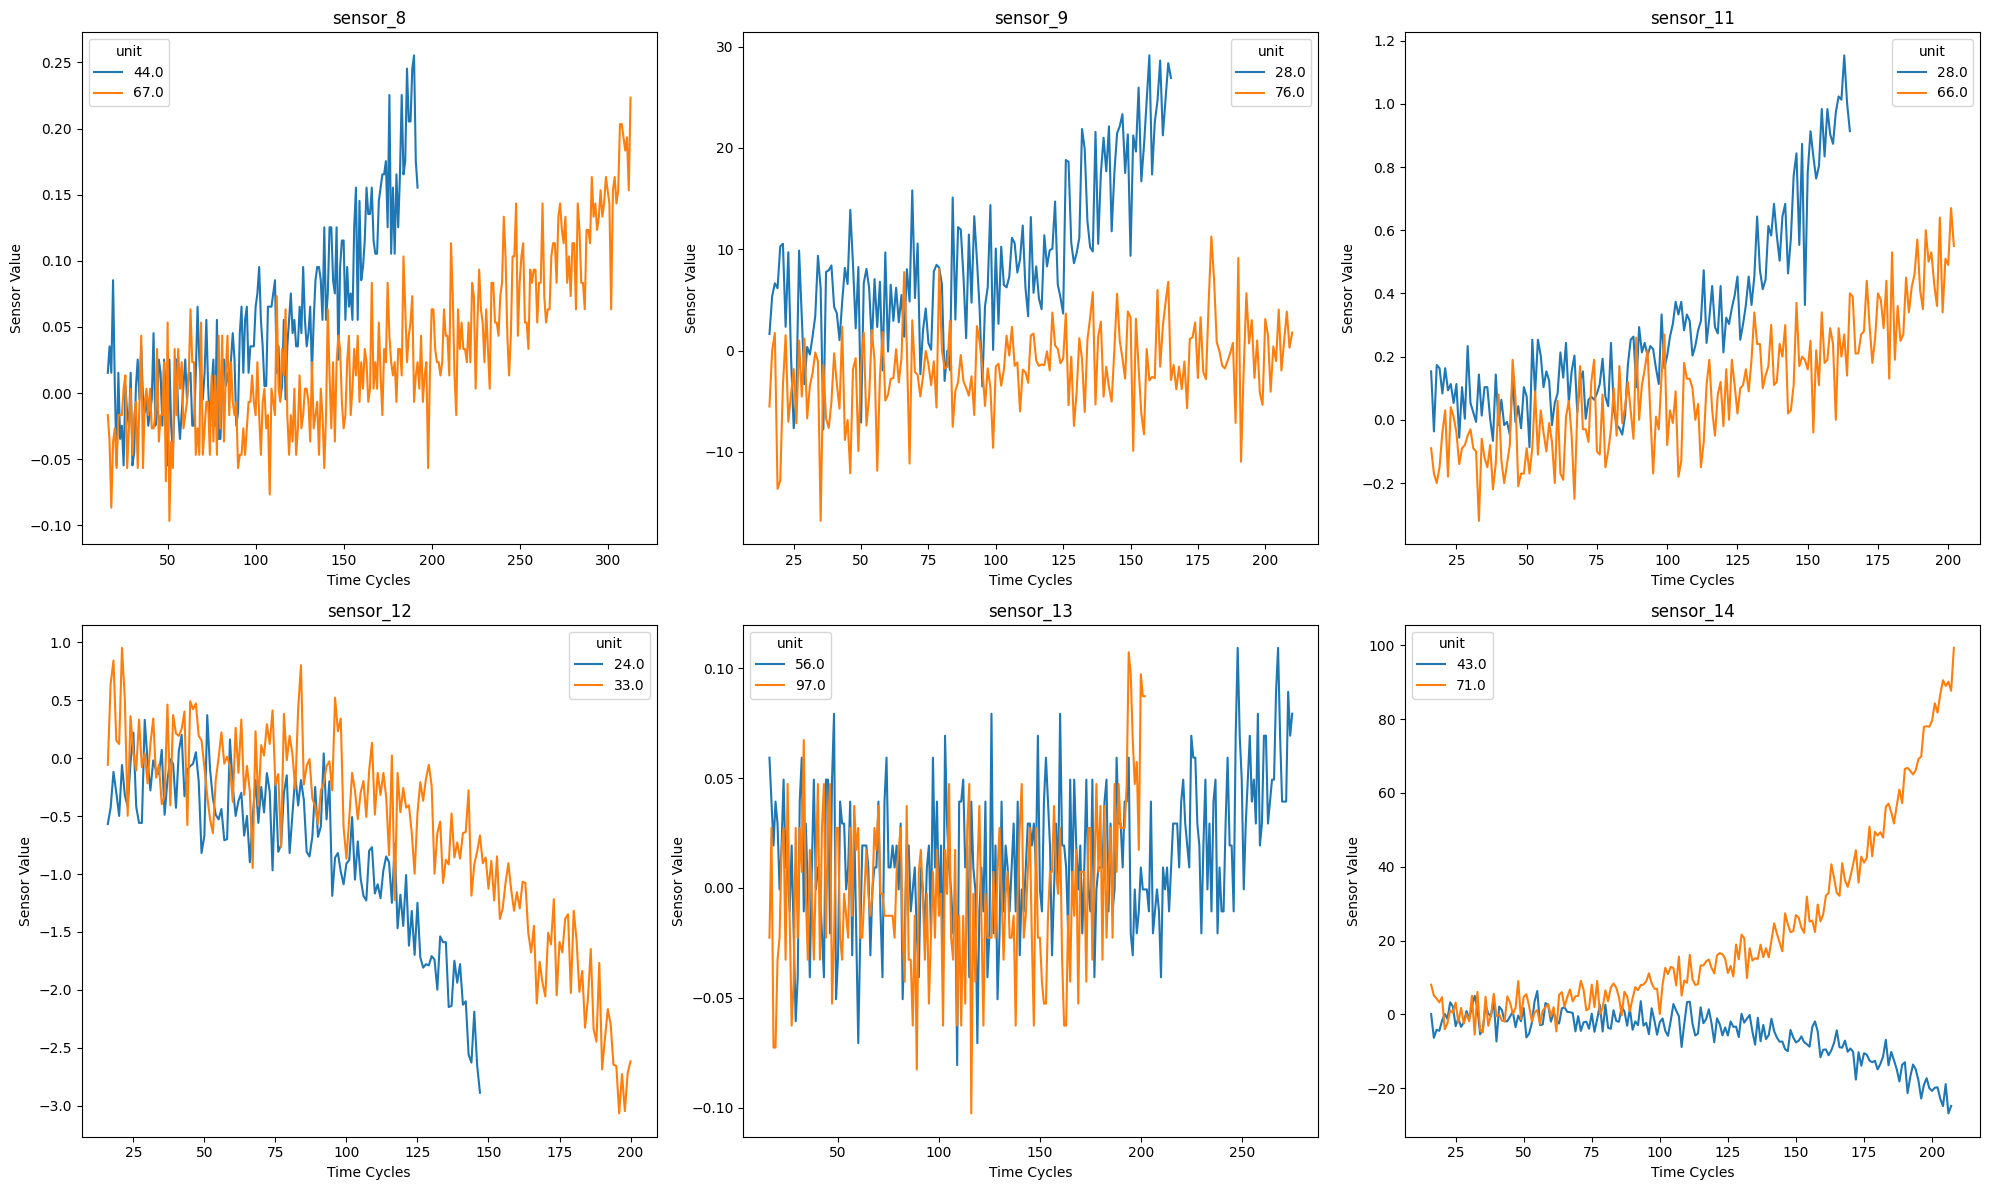

In [10]:
SELECTED_SENSORS = [
    "sensor_8",
    "sensor_9",
    "sensor_11",
    "sensor_12",
    "sensor_13",
    "sensor_14",
]

first_avg_values = (
    train[train["time_cycles"] <= 20]
    .groupby("unit")[SELECTED_SENSORS]
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(2, 3, figsize=(20, 12))
for i, sensor in enumerate(SELECTED_SENSORS):
    avg_sorted = first_avg_values.sort_values(sensor)
    engine_a, engine_b = avg_sorted["unit"].iloc[0], avg_sorted["unit"].iloc[-1]
    sns.lineplot(
        data=train[train["unit"].isin([engine_a, engine_b])],
        x="time_cycles",
        y=sensor,
        hue="unit",
        ax=ax.flatten()[i],
        palette="tab10",
    )
    ax.flatten()[i].set_title(sensor)
    ax.flatten()[i].set_xlabel("Time Cycles")
    ax.flatten()[i].set_ylabel("Sensor Value")

plt.tight_layout()
plt.show()

## 6. Apply Rolling Window


Rolling window is a technique where you use a fixed-size subset of the most recent observations to train your model and make predictions. The window moves forward through the time series, discarding the oldest observation and including the next new observation at each step.

We will be transforming the original time series into sliding windows of length 30.


In [11]:
from tsfresh.utilities.dataframe_functions import roll_time_series


class RollTimeSeries(BaseEstimator, TransformerMixin):
    def __init__(self, min_timeshift, max_timeshift, rolling_direction):
        self.min_timeshift = min_timeshift
        self.max_timeshift = max_timeshift
        self.rolling_direction = rolling_direction

    def fit(self, X):
        return self

    def transform(self, X):
        _start = datetime.now()
        print("Start Rolling TS")
        X_t = roll_time_series(
            X,
            column_id="unit",
            column_sort="time_cycles",
            rolling_direction=self.rolling_direction,
            min_timeshift=self.min_timeshift,
            max_timeshift=self.max_timeshift,
        )
        print(f"Done Rolling TS in {datetime.now() - _start}")
        return X_t

In [12]:
train = RollTimeSeries(
    min_timeshift=29, max_timeshift=29, rolling_direction=1
).fit_transform(train)

Start Rolling TS


Rolling: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Done Rolling TS in 0:00:07.264105


## 7. Features Engineering


For features engineering, we will be using TSFresh to extracts a large number of features from time series and has a built-in features filtering procedure.


In [13]:
# Chosen features to be extracted by tsfresh
tsfresh_calc = {
    "mean_change": None,
    "mean": None,
    "standard_deviation": None,
    "root_mean_square": None,
    "last_location_of_maximum": None,
    "first_location_of_maximum": None,
    "last_location_of_minimum": None,
    "first_location_of_minimum": None,
    "maximum": None,
    "minimum": None,
    "time_reversal_asymmetry_statistic": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "c3": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "cid_ce": [{"normalize": True}, {"normalize": False}],
    "autocorrelation": [
        {"lag": 0},
        {"lag": 1},
        {"lag": 2},
        {"lag": 3},
    ],
    "partial_autocorrelation": [
        {"lag": 0},
        {"lag": 1},
        {"lag": 2},
        {"lag": 3},
    ],
    "linear_trend": [{"attr": "intercept"}, {"attr": "slope"}, {"attr": "stderr"}],
    "augmented_dickey_fuller": [
        {"attr": "teststat"},
        {"attr": "pvalue"},
        {"attr": "usedlag"},
    ],
    "linear_trend_timewise": [{"attr": "intercept"}, {"attr": "slope"}],
    "lempel_ziv_complexity": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 100},
    ],
    "permutation_entropy": [
        {"tau": 1, "dimension": 3},
        {"tau": 1, "dimension": 4},
        {"tau": 1, "dimension": 5},
        {"tau": 1, "dimension": 6},
        {"tau": 1, "dimension": 7},
    ],
    "fft_coefficient": [
        {"coeff": 0, "attr": "abs"},
        {"coeff": 1, "attr": "abs"},
        {"coeff": 2, "attr": "abs"},
        {"coeff": 3, "attr": "abs"},
        {"coeff": 4, "attr": "abs"},
        {"coeff": 5, "attr": "abs"},
        {"coeff": 6, "attr": "abs"},
        {"coeff": 7, "attr": "abs"},
        {"coeff": 8, "attr": "abs"},
        {"coeff": 9, "attr": "abs"},
        {"coeff": 10, "attr": "abs"},
    ],
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
}

In [14]:
from tsfresh import extract_features


class TSFreshFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, calc=tsfresh_calc):
        self.calc = calc

    def _clean_features(self, X):
        old_shape = X.shape
        X_t = X.T.drop_duplicates().T
        print(f"Droped {old_shape[1] - X_t.shape[1]} duplicate features")

        old_shape = X_t.shape
        X_t = X_t.dropna(axis=1)
        print(f"Droped {old_shape[1] - X_t.shape[1]} features with NA values")
        return X_t

    def fit(self, X):
        return self

    def transform(self, X):
        _start = datetime.now()
        print("Start Extracting Features")
        X_t = extract_features(
            X[
                ["id", "time_cycles"]
                + X.columns[X.columns.str.startswith("sensor")].tolist()
            ],
            column_id="id",
            column_sort="time_cycles",
            default_fc_parameters=self.calc,
        )
        print(f"Done Extracting Features in {datetime.now() - _start}")
        X_t = self._clean_features(X_t)
        return X_t

In [15]:
train = TSFreshFeaturesExtractor().fit_transform(train)
train.columns

Start Extracting Features


Feature Extraction: 100%|██████████| 20/20 [06:35<00:00, 19.76s/it]


Done Extracting Features in 0:07:01.231975
Droped 19 duplicate features
Droped 14 features with NA values


Index(['sensor_2__mean_change', 'sensor_2__mean',
       'sensor_2__standard_deviation', 'sensor_2__root_mean_square',
       'sensor_2__last_location_of_maximum',
       'sensor_2__first_location_of_maximum',
       'sensor_2__last_location_of_minimum',
       'sensor_2__first_location_of_minimum', 'sensor_2__maximum',
       'sensor_2__minimum',
       ...
       'sensor_21__fft_coefficient__attr_"abs"__coeff_5',
       'sensor_21__fft_coefficient__attr_"abs"__coeff_6',
       'sensor_21__fft_coefficient__attr_"abs"__coeff_7',
       'sensor_21__fft_coefficient__attr_"abs"__coeff_8',
       'sensor_21__fft_coefficient__attr_"abs"__coeff_9',
       'sensor_21__fft_coefficient__attr_"abs"__coeff_10',
       'sensor_21__fft_aggregated__aggtype_"centroid"',
       'sensor_21__fft_aggregated__aggtype_"variance"',
       'sensor_21__fft_aggregated__aggtype_"skew"',
       'sensor_21__fft_aggregated__aggtype_"kurtosis"'],
      dtype='object', length=822)

Right now we have about 822 features, and since this is a huge number of features, we will have highly correlated features which needs to be remove.


Hence, we will be applying both PCA (from Scikit-Learn) and Features Selection (from tsfresh) to solve this problem.


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


class CustomPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=None, random_state=None):
        self.n_components = n_components
        self.random_state = random_state

    def fit(self, X):
        assert "unit" not in X.columns, "columns should be only features"
        self.ftr_columns = X.columns

        self.scaler = StandardScaler()
        X_sc = self.scaler.fit_transform(X[self.ftr_columns].values)

        self.pca = PCA(n_components=self.n_components, random_state=self.random_state)
        self.pca.fit_transform(X_sc)
        return self

    def transform(self, X):
        X_sc = self.scaler.transform(X[self.ftr_columns].values)
        X_pca = self.pca.transform(X_sc)
        return pd.DataFrame(X_pca, index=X.index)

In [17]:
# Apply CustomPCA and print the Principle Components
train = CustomPCA(n_components=40).fit_transform(train)
train.head()

0         1         2         3         4         5   \
1.0 45.0 -11.020062  0.067080 -0.082502  6.831861 -2.500179  0.096795   
    46.0 -10.795412  0.431491 -0.262794  6.700044 -2.579259 -0.112635   
    47.0 -11.175847  0.432684 -0.245027  6.996362 -2.998179 -0.244741   
    48.0 -10.994828  0.444239 -0.206944  7.142485 -2.524128 -0.133881   
    49.0 -10.610900  0.357260 -0.166057  6.912504 -1.765605 -0.385747   

                6         7         8         9   ...        30        31  \
1.0 45.0  8.654691 -4.018964 -4.285490  1.884039  ... -1.552702 -1.261718   
    46.0  9.637422 -4.164503 -3.670378  2.393083  ... -1.201482 -1.052994   
    47.0  9.557316 -3.903530 -3.765421  2.583722  ... -0.876499 -0.595314   
    48.0  8.775597 -3.678190 -3.047914  2.363588  ... -0.116149 -0.588231   
    49.0  7.931655 -3.858767 -2.393717  2.333043  ... -0.117286 -0.221177   

                32        33        34        35        36        37  \
1.0 45.0  3.132257  2.411777  3.044196 -0.864998 -1.250640  0.780155   
    46.0  2.903877  3.195243  3.184400 -1.244644 -1.522164  0.928204   
    47.0  2.672059  2.608161  3.374021 -1.526291 -1.388488  1.353285   
    48.0  2.723094  2.372599  3.736801 -1.319021 -1.618868  0.408053   
    49.0  2.400008  2.441851  3.158524 -1.148379 -0.817827  0.413173   

                38        39  
1.0 45.0 -1.487631 -2.748001  
    46.0 -1.222625 -2.444779  
    47.0 -0.975430 -1.622397  
    48.0 -1.188044 -0.933014  
    49.0 -1.347057 -0.138605  

[5 rows x 40 columns]

Now, we have 40 principle components. We will apply tsfresh feature selection to automatically pick the best features.


In [18]:
from tsfresh import select_features

class TSFreshFeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, fdr_level=0.001):
        self.fdr_level = fdr_level

    def fit(self, X):
        rul = calculate_RUL(
            X.index.to_frame(name=["unit", "time_cycles"]).reset_index(drop=True),
            upper_threshold=135,
        )

        X_t = select_features(X, rul, fdr_level=self.fdr_level)
        self.selected_ftr = X_t.columns

        print(
            f"Selected {len(self.selected_ftr)} out of {X.shape[1]} features: "
            f"{self.selected_ftr.to_list()}"
        )
        return self

    def transform(self, X):
        return X[self.selected_ftr]

In [19]:
train = TSFreshFeaturesSelector(fdr_level=0.001).fit_transform(train)
train.head()

Selected 9 out of 40 features: [0, 2, 3, 4, 5, 1, 37, 10, 15]


0         2         3         4         5         1   \
1.0 45.0 -11.020062 -0.082502  6.831861 -2.500179  0.096795  0.067080   
    46.0 -10.795412 -0.262794  6.700044 -2.579259 -0.112635  0.431491   
    47.0 -11.175847 -0.245027  6.996362 -2.998179 -0.244741  0.432684   
    48.0 -10.994828 -0.206944  7.142485 -2.524128 -0.133881  0.444239   
    49.0 -10.610900 -0.166057  6.912504 -1.765605 -0.385747  0.357260   

                37        10        15  
1.0 45.0  0.780155  1.317476  0.466010  
    46.0  0.928204  1.452650  0.313887  
    47.0  1.353285  1.105859  0.086995  
    48.0  0.408053  1.346626 -0.084197  
    49.0  0.413173  0.814948  0.023618

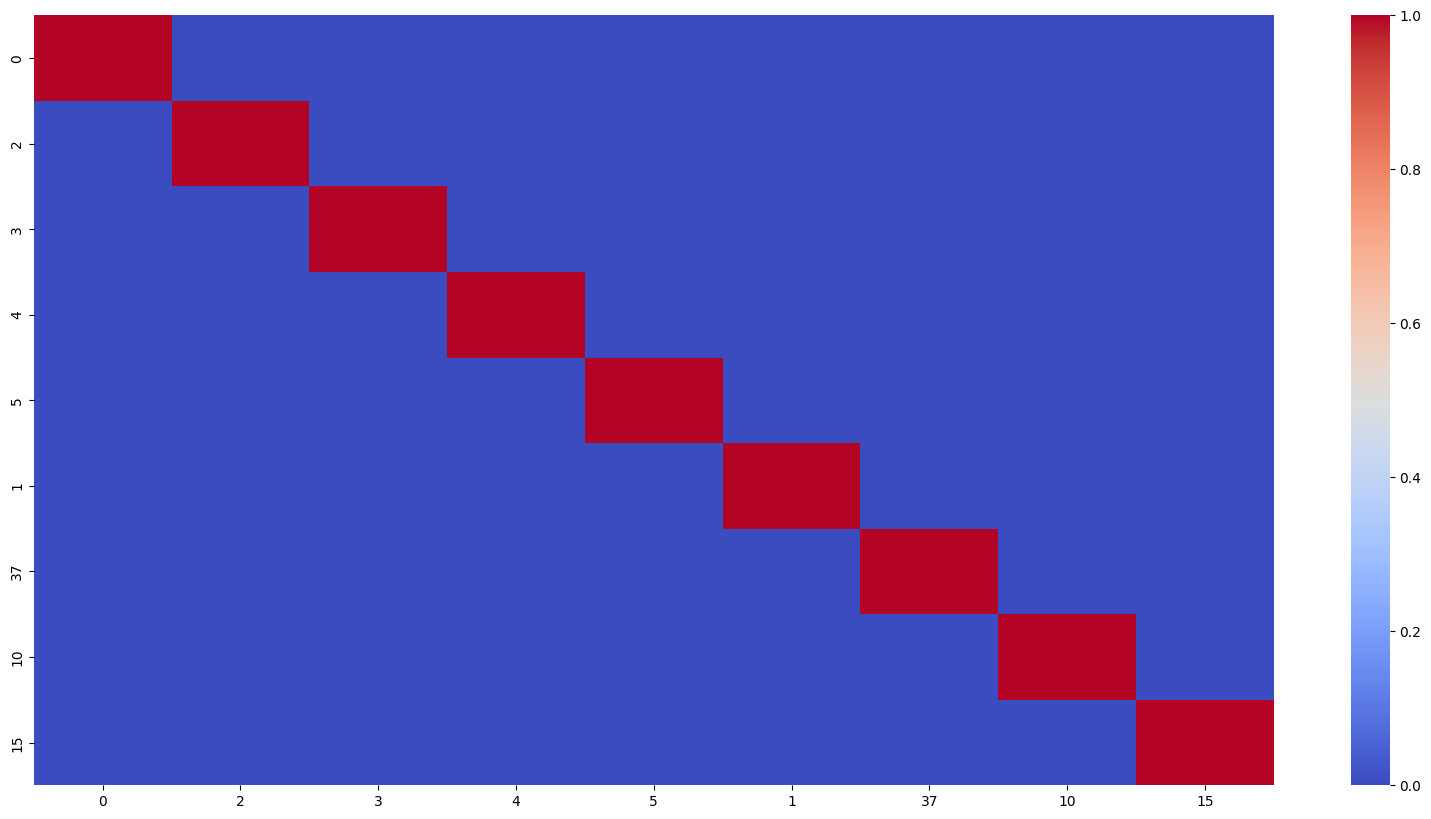

In [20]:
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr(), cmap="coolwarm", annot=False)
plt.show()

After preprocessing, we left with features that are highly independent of each other which should give us a more robust ML models.
